# Ginkgo clustering environment

## Setup

In [ ]:
%matplotlib inline

import copy
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
import gym
import logging
from tqdm import trange

from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
from stable_baselines.deepq import MlpPolicy as DQNMlpPolicy
from stable_baselines import PPO2, ACER, DQN
from stable_baselines.bench import Monitor
from stable_baselines import results_plotter
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import BaseCallback

sys.path.append("../")
from ginkgo_rl import GinkgoLikelihoodEnv, GinkgoLikelihood1DEnv, GinkgoLikelihoodShuffledEnv, GinkgoEvaluator


In [2]:
# Logging setup
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

for key in logging.Logger.manager.loggerDict:
    if "ginkgo_rl" not in key:
        logging.getLogger(key).setLevel(logging.ERROR)
        
def set_output(on=True):
    for key in logging.Logger.manager.loggerDict:
        if "ginkgo_rl" in key:
            logging.getLogger(key).setLevel(logging.DEBUG if on else logging.ERROR)


## Let's play a round of clustering manually

In [3]:
set_output(True)
env = gym.make("GinkgoLikelihoodShuffled-v0")
state = env.reset()
env.render()

11:29 ginkgo_rl.envs.ginkg DEBUG   Initializing environment
11:29 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 9 leaves
11:29 ginkgo_rl.envs.ginkg DEBUG   Resetting environment
11:29 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 8 leaves
11:29 ginkgo_rl.envs.ginkg INFO    8 particles:
11:29 ginkgo_rl.envs.ginkg INFO      p[ 0] = (102.3,  60.7,  58.5,  57.8)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  5.5,   3.3,  -1.6,  -1.3)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  4.7,   2.7,   2.8,   2.6)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  4.0,   1.1,   1.2,   3.3)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 4] = ( 46.3,  26.8,  27.4,  26.0)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 5] = (111.7,  66.6,  64.4,  62.4)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 6] = (100.9,  59.1,  59.6,  55.9)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 9] = ( 32.6,  10.6,  18.7,  24.2)


In [4]:
# Merge two particles
action = 3, 6

state, reward, done, info = env.step(action)
env.render()

print(f"Reward: {reward}")
print(f"Done: {done}")
print(f"Info: {info}")

# Repeat this cell as often as you feel like


11:29 ginkgo_rl.envs.ginkg DEBUG   Environment step. Action: (2, 6)
11:29 ginkgo_rl.envs.ginkg DEBUG   Computing log likelihood of action (2, 6): -6.106024742126465
11:29 ginkgo_rl.envs.ginkg DEBUG   Merging particles 2 and 6. New state has 7 particles.
11:29 ginkgo_rl.envs.ginkg INFO    7 particles:
11:29 ginkgo_rl.envs.ginkg INFO      p[ 0] = (  4.7,   2.7,   2.8,   2.6)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 1] = (104.9,  60.2,  60.8,  59.2)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  5.5,   3.3,  -1.6,  -1.3)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 4] = ( 46.3,  26.8,  27.4,  26.0)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 5] = (102.3,  60.7,  58.5,  57.8)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 7] = (111.7,  66.6,  64.4,  62.4)
11:29 ginkgo_rl.envs.ginkg INFO      p[ 9] = ( 32.6,  10.6,  18.7,  24.2)


Reward: -6.106024742126465
Done: False
Info: {'legal': True, 'illegal_action_counter': 0, 'replace_illegal_action': False, 'i': 2, 'j': 6}


In [5]:
env.close()

## Env checker

In [6]:
set_output(False)
env = gym.make("GinkgoLikelihoodShuffled-v0")

check_env(env)

for i in range(env.n_max):
    assert i == env.inverse_permutation[env.permutation[i]] == env.permutation[env.inverse_permutation[i]]
    
env.close()

/Users/johannbrehmer/anaconda3/envs/rl/lib/python3.7/site-packages/stable_baselines/common/env_checker.py:202: UserWarning: Your observation has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector
  warnings.warn("Your observation has an unconventional shape (neither an image, nor a 1D vector). "


## Evaluation routine

In [7]:
set_output(False)
evaluator = GinkgoEvaluator(n_jets=8)


## True log likelihoods

In [8]:
set_output(False)
evaluator.eval_true("Truth")


## Maximum log likelihood (through Trellis)

In [9]:
set_output(False)
evaluator.eval_exact_trellis("ML (Trellis)")


## Random clusterings

In [10]:
set_output(False)
evaluator.eval_random("Random", env_name="GinkgoLikelihood-v0")


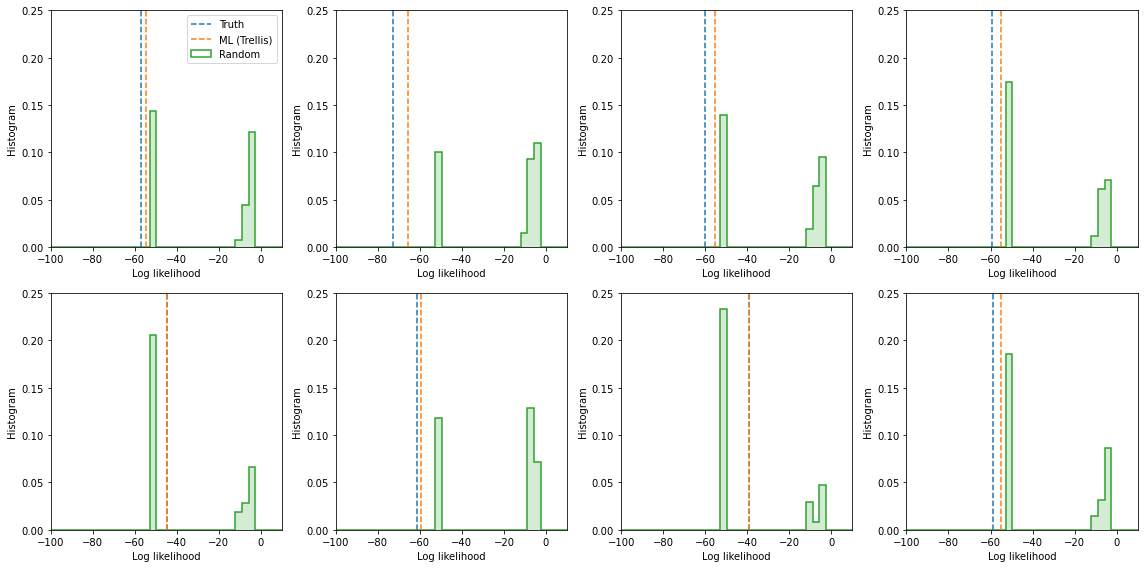

In [11]:
_ = evaluator.plot_log_likelihoods()

## RL preparation

In [12]:
log_dirs = []
models = {}
env_names = {}

def train(algorithm, algo_class, policy_class, env_name="GinkgoLikelihoodShuffled1D-v0", n_steps=20000, eval_freq=1000):
    log_dir = f"./logs/{algorithm}/"
    log_dirs.append(log_dir)

    set_output(False)
    env = gym.make(env_name)
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(env, log_dir)

    model = algo_class(policy_class, env, verbose=0)
    model.learn(total_timesteps=n_steps)
    
    models[algorithm] = model
    env_names[algorithm] = env_name
    env.close()


## PPO

In [13]:
train("ppo", PPO2, MlpPolicy, env_name="GinkgoLikelihoodShuffled-v0")

/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")
/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:333: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )


## DQN

In [ ]:
train("dqn", DQN, DQNMlpPolicy)

/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


## Training progress

In [ ]:
results_plotter.plot_results(log_dirs[1:2], 1e5, results_plotter.X_TIMESTEPS, "Ginkgo")


## Evaluate

In [ ]:
evaluator.eval("PPO", models["ppo"], "GinkgoLikelihoodShuffled-v0)

In [ ]:
evaluator.eval("DQN", models["dqn"], "GinkgoLikelihoodShuffled1D-v0)

In [ ]:
evaluator.plot_log_likelihoods()